In [1]:
import re
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
plt.style.use('seaborn-whitegrid')
%matplotlib inline

# Loading the dataset and preprocessing
The dataset is available at: https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008

In [2]:
#Reading the dataset, Null values are represented by ?
data = pd.read_csv("diabetic_data.csv", na_values=["?", 'None'], low_memory=False)

In [3]:
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


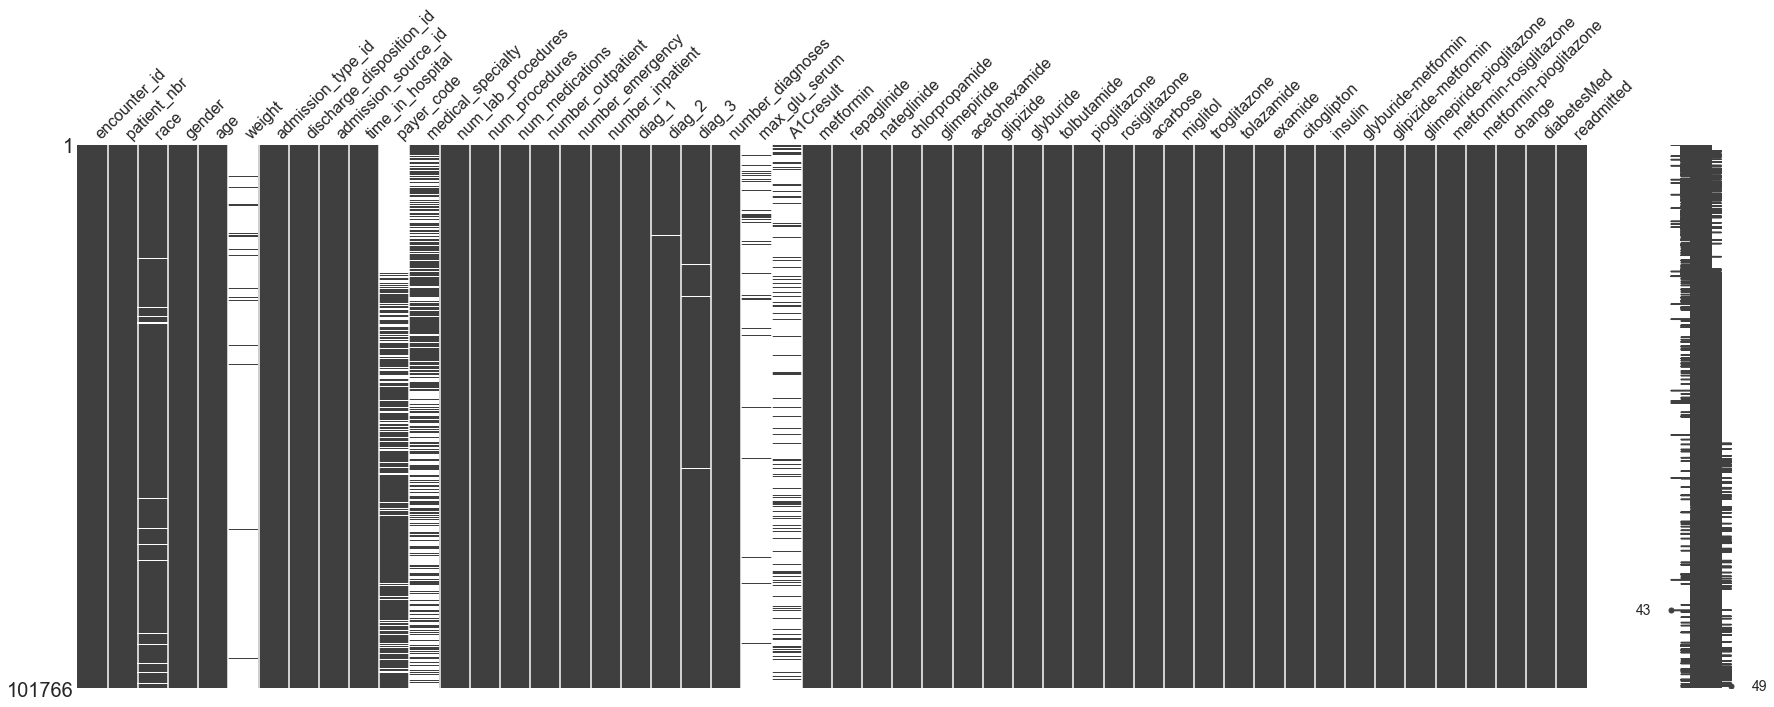

In [4]:
#Get a visual of missing data
missingno.matrix(data, figsize = (30,10))

In [5]:
#Get the proportion of missing values per column
prop_na = data.columns.map(lambda x: {x: round(float(data[x].isnull().sum())/len(data[x]),4)} )

In [6]:
prop_na

Index([            {'encounter_id': 0.0},              {'patient_nbr': 0.0},
                        {'race': 0.0223},                   {'gender': 0.0},
                            {'age': 0.0},                {'weight': 0.9686},
              {'admission_type_id': 0.0}, {'discharge_disposition_id': 0.0},
            {'admission_source_id': 0.0},         {'time_in_hospital': 0.0},
                  {'payer_code': 0.3956},     {'medical_specialty': 0.4908},
             {'num_lab_procedures': 0.0},           {'num_procedures': 0.0},
                {'num_medications': 0.0},        {'number_outpatient': 0.0},
               {'number_emergency': 0.0},         {'number_inpatient': 0.0},
                      {'diag_1': 0.0002},                {'diag_2': 0.0035},
                       {'diag_3': 0.014},         {'number_diagnoses': 0.0},
               {'max_glu_serum': 0.9475},             {'A1Cresult': 0.8328},
                      {'metformin': 0.0},              {'repaglinide': 0.0},

In [7]:
#Remove non informative columns and columns with very high missing values proportion
data = data.drop(['encounter_id', 'patient_nbr', 'weight','payer_code', 'medical_specialty', 'max_glu_serum', 'A1Cresult'], axis=1)

In [8]:
data.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,Caucasian,Female,[0-10),6,25,1,1,41,0,1,...,No,No,No,No,No,No,No,No,No,NO
1,Caucasian,Female,[10-20),1,1,7,3,59,0,18,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,AfricanAmerican,Female,[20-30),1,1,7,2,11,5,13,...,No,No,No,No,No,No,No,No,Yes,NO
3,Caucasian,Male,[30-40),1,1,7,2,44,1,16,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,Caucasian,Male,[40-50),1,1,7,1,51,0,8,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [9]:
#Get informations about the columns types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 43 columns):
race                        99493 non-null object
gender                      101766 non-null object
age                         101766 non-null object
admission_type_id           101766 non-null int64
discharge_disposition_id    101766 non-null int64
admission_source_id         101766 non-null int64
time_in_hospital            101766 non-null int64
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient            101766 non-null int64
diag_1                      101745 non-null object
diag_2                      101408 non-null object
diag_3                      100343 non-null object
number_diagnoses            101766 non-null int64
metformin                   101766

In [10]:
#Droping missing values
data.dropna(inplace=True)

In [11]:
data.shape

(98053, 43)

In [12]:
#One way to identify categorical variables is to check the number of unique values per column
unique_values = data.columns.map(lambda x: {x : data[x].nunique()})

In [13]:
unique_values

Index([                     {'race': 5},                    {'gender': 3},
                            {'age': 10},         {'admission_type_id': 8},
       {'discharge_disposition_id': 26},      {'admission_source_id': 17},
               {'time_in_hospital': 14},      {'num_lab_procedures': 118},
                  {'num_procedures': 7},          {'num_medications': 75},
              {'number_outpatient': 39},         {'number_emergency': 33},
               {'number_inpatient': 20},                  {'diag_1': 713},
                        {'diag_2': 740},                  {'diag_3': 786},
               {'number_diagnoses': 14},                 {'metformin': 4},
                     {'repaglinide': 4},               {'nateglinide': 4},
                  {'chlorpropamide': 4},               {'glimepiride': 4},
                   {'acetohexamide': 2},                 {'glipizide': 4},
                       {'glyburide': 4},               {'tolbutamide': 2},
                    {'pio

In [14]:
#The number of diagnoses in the diag1, diag2, diag3 columns is very large. One hot encoding of theses three columns will result in mere than 2000 features
diag_1_n = data['diag_1'].value_counts()
diag_2_n = data['diag_2'].value_counts()
diag_3_n = data['diag_3'].value_counts()

In [15]:
#There are only low proportion of the categories that have a frequency of more than 100 which might cause a problem when splitting the train/test
#lets recode the categories with less than min freq as Other
min_freq = 100

print("Diag 1: {} of the catgories appear less than 100 times in the dataset".format(round(len(diag_1_n[diag_1_n<min_freq])/len(diag_1_n),2)))
print("Diag 2: {} of the catgories appear less than 100 times in the dataset".format(round(len(diag_2_n[diag_2_n<min_freq])/len(diag_2_n),2)))
print("Diag 3: {} of the catgories appear less than 100 times in the dataset".format(round(len(diag_3_n[diag_3_n<min_freq])/len(diag_3_n),2)))

Diag 1: 0.81 of the catgories appear less than 100 times in the dataset
Diag 2: 0.82 of the catgories appear less than 100 times in the dataset
Diag 3: 0.83 of the catgories appear less than 100 times in the dataset


In [16]:
# Let's recode the categories with a frequency lower than 100 as other

diag1_recode  = data['diag_1'].map(lambda x: 'other' if diag_1_n[x] < min_freq else x)
diag2_recode  = data['diag_2'].map(lambda x: 'other' if diag_2_n[x] < min_freq else x)
diag3_recode  = data['diag_3'].map(lambda x: 'other' if diag_3_n[x] < min_freq else x)


In [17]:
# Saving the changes in a copy of dataset
data_rec1 = data.copy()

In [18]:
data_rec1['diag_1'] = diag1_recode
data_rec1['diag_2'] = diag2_recode
data_rec1['diag_3'] = diag3_recode

In [19]:
#Format the age as ordered factors
age_intervals = data_rec1['age'].value_counts().index

age_dict ={}
compt = 1
for k in sorted(age_intervals):
    age_dict[k] = compt
    compt+=1

age_dict



{'[0-10)': 1,
 '[10-20)': 2,
 '[20-30)': 3,
 '[30-40)': 4,
 '[40-50)': 5,
 '[50-60)': 6,
 '[60-70)': 7,
 '[70-80)': 8,
 '[80-90)': 9,
 '[90-100)': 10}

In [20]:
age_intervals = data_rec1['age'].map(lambda x: age_dict[x] )
age_intervals.value_counts()


8     25306
7     21809
9     16702
6     16697
5      9265
4      3548
10     2717
3      1478
2       466
1        65
Name: age, dtype: int64

In [21]:
#The 0-10 interval is under represented. let's merge it with the 10-20
age_intervals = age_intervals.map(lambda x: 2 if x == 1 else x)
age_intervals.value_counts()

8     25306
7     21809
9     16702
6     16697
5      9265
4      3548
10     2717
3      1478
2       531
Name: age, dtype: int64

In [22]:
data_rec1['age'] = age_intervals

In [23]:
#Remove the columns that contain only a single category
data_f1 = data_rec1.copy()
cols = data_f1.columns

for col in cols:
    if data_f1[col].nunique() < 2:
        data_f1.drop([col], axis=1, inplace=True)
    

In [24]:
 data_f1.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'metformin', 'repaglinide',
       'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide',
       'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
       'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-pioglitazone', 'change',
       'diabetesMed', 'readmitted'],
      dtype='object')

In [25]:
cat_columns = ['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'metformin', 'repaglinide',
       'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide',
       'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
       'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-pioglitazone', 'change',
       'diabetesMed', 'readmitted']

In [26]:
#Check how the categorical columns are balanced
def check_features_balance(data, cat_cols):
    for col in cat_cols:
        print(col)
        print( data[col].value_counts())
        print('-'*40)

check_features_balance(data_f1,  data_f1.columns)

race
Caucasian          75079
AfricanAmerican    18881
Hispanic            1984
Other               1484
Asian                625
Name: race, dtype: int64
----------------------------------------
gender
Female             52833
Male               45219
Unknown/Invalid        1
Name: gender, dtype: int64
----------------------------------------
age
8     25306
7     21809
9     16702
6     16697
5      9265
4      3548
10     2717
3      1478
2       531
Name: age, dtype: int64
----------------------------------------
admission_type_id
1    52178
3    18194
2    17543
6     5135
5     4661
8      312
7       20
4       10
Name: admission_type_id, dtype: int64
----------------------------------------
discharge_disposition_id
1     57610
3     13564
6     12626
18     3624
2      2049
22     1970
11     1606
5      1127
25      941
4       756
7       592
23      400
13      396
14      368
28      137
8       106
15       63
24       48
9        21
17       14
16       11
19        8
10 

No        97384
Steady      660
Up            6
Down          3
Name: glyburide-metformin, dtype: int64
----------------------------------------
glipizide-metformin
No        98040
Steady       13
Name: glipizide-metformin, dtype: int64
----------------------------------------
glimepiride-pioglitazone
No        98052
Steady        1
Name: glimepiride-pioglitazone, dtype: int64
----------------------------------------
metformin-pioglitazone
No        98052
Steady        1
Name: metformin-pioglitazone, dtype: int64
----------------------------------------
change
No    52774
Ch    45279
Name: change, dtype: int64
----------------------------------------
diabetesMed
Yes    75351
No     22702
Name: diabetesMed, dtype: int64
----------------------------------------
readmitted
NO     52338
>30    34649
<30    11066
Name: readmitted, dtype: int64
----------------------------------------


In [27]:
#It is clear that few of the columns are not informative  as they contain 2 categories of which one is very underrepresented.
#Removing: 'acetohexamide', 'tolbutamide', 'miglitol', 'glipizide-metformin', 'glimepiride-pioglitazone'
cat_columns = ['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'diag_1',
       'diag_2', 'diag_3', 'metformin', 'repaglinide',
       'nateglinide', 'chlorpropamide', 'glimepiride', 
       'glipizide', 'glyburide', 'pioglitazone',
       'rosiglitazone', 'acarbose', 'troglitazone', 'tolazamide',
       'insulin', 'glyburide-metformin',
       'metformin-pioglitazone', 'change',
       'diabetesMed', 'readmitted']

In [28]:
data_f2 = data_f1.copy()
data_f2 = data_f2[cat_columns]

In [29]:
#Let's check again how the feature distributions
check_features_balance(data_f2, cat_columns)

race
Caucasian          75079
AfricanAmerican    18881
Hispanic            1984
Other               1484
Asian                625
Name: race, dtype: int64
----------------------------------------
gender
Female             52833
Male               45219
Unknown/Invalid        1
Name: gender, dtype: int64
----------------------------------------
age
8     25306
7     21809
9     16702
6     16697
5      9265
4      3548
10     2717
3      1478
2       531
Name: age, dtype: int64
----------------------------------------
admission_type_id
1    52178
3    18194
2    17543
6     5135
5     4661
8      312
7       20
4       10
Name: admission_type_id, dtype: int64
----------------------------------------
discharge_disposition_id
1     57610
3     13564
6     12626
18     3624
2      2049
22     1970
11     1606
5      1127
25      941
4       756
7       592
23      400
13      396
14      368
28      137
8       106
15       63
24       48
9        21
17       14
16       11
19        8
10 

In [30]:
#There still features with  categories that are highly underrepresented
#let's recode the categories that have less than min_freq as 'other'. 
#For measurement columns having 'Up' and 'Down' as values, merge these in a single category called abnormal

min_freq = 100

for col in cat_columns:
    if set(['Up', 'Down']).issubset(list(data_f2[col])):
        #Replace all values "Up" and "Down" with "Abnormal"
        new_vec = data_f2[col].map(lambda x : 'Abnormal' if x in["Up", 'Down'] else x)
        data_f2[col] = new_vec
    else:
        #The categories with a frequency of less than 100 are recoded as 'other'
        count = data_f2[col].value_counts()
        new_vec = data_f2[col].map(lambda x : 'other' if count[x] < min_freq else x)
        data_f2[col] = new_vec
    

In [31]:
#Let's check again how the feature distributions
check_features_balance(data_f2, cat_columns)

race
Caucasian          75079
AfricanAmerican    18881
Hispanic            1984
Other               1484
Asian                625
Name: race, dtype: int64
----------------------------------------
gender
Female    52833
Male      45219
other         1
Name: gender, dtype: int64
----------------------------------------
age
8     25306
7     21809
9     16702
6     16697
5      9265
4      3548
10     2717
3      1478
2       531
Name: age, dtype: int64
----------------------------------------
admission_type_id
1        52178
3        18194
2        17543
6         5135
5         4661
8          312
other       30
Name: admission_type_id, dtype: int64
----------------------------------------
discharge_disposition_id
1        57610
3        13564
6        12626
18        3624
2         2049
22        1970
11        1606
5         1127
25         941
4          756
7          592
23         400
13         396
14         368
other      181
28         137
8          106
Name: discharge_dispos

In [32]:
#There are still few features with low frequencies for few of their categories. let's drop them
cols_to_remove = ['nateglinide', 'chlorpropamide', 'acarbose', 'troglitazone', 'tolazamide', 'glyburide-metformin',
                 'metformin-pioglitazone']
data_f2.drop(cols_to_remove, axis=1, inplace=True)

In [33]:
#Now Let's reform our dataset by concatenating categorical features and continuous one
data_f2 = pd.concat([data_f2, data.loc[:,['time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient']]], axis=1)

In [34]:
# Remove the single row having 'other' as value
data_f2 = data_f2[data_f2['gender']!='other']

# Exploratory data analysis and dataset preparation for ML

In [35]:
# Check if the categories of the outcome are balanced 
data_f2['readmitted'].value_counts()

NO     52337
>30    34649
<30    11066
Name: readmitted, dtype: int64

In [36]:
#Separate the features from the outcome
X = data_f2.drop(['readmitted'], axis=1)
Y = data_f2['readmitted']

In [37]:
#For this analysis, let's consider only 2 groups: Admitted:0, non admitted:1
Y_new = Y.map(lambda x : 0 if x == "NO" else 1)

In [38]:
Y_new.value_counts()

0    52337
1    45715
Name: readmitted, dtype: int64

In [39]:
#Let's split separate the categorical columns from the continuous columns for data exploration
continuous_columns = ['time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient']

categorical_columns = [i for i in X.columns if i not in continuous_columns]

In [40]:
X_cat = X.loc[:, categorical_columns]
X_cont = X.loc[:, continuous_columns]

In [41]:
#Visualize categorical data
X_cat_vis = X_cat
X_cat_vis['readmitted'] = Y_new
X_cat_vis.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'diag_1', 'diag_2',
       'diag_3', 'metformin', 'repaglinide', 'glimepiride', 'glipizide',
       'glyburide', 'pioglitazone', 'rosiglitazone', 'insulin', 'change',
       'diabetesMed', 'readmitted'],
      dtype='object')

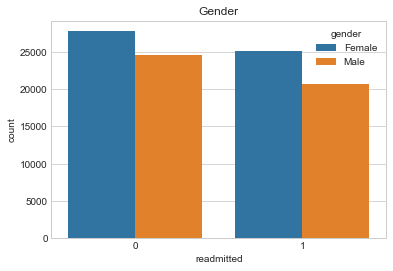

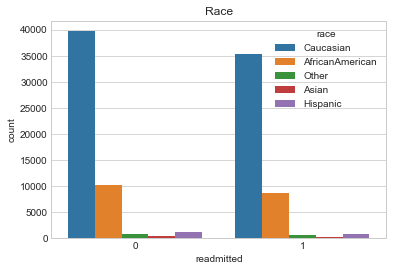

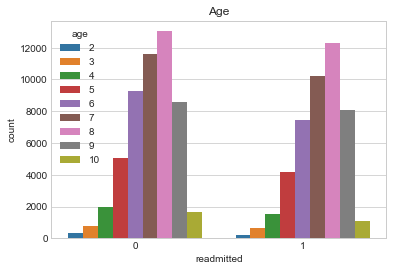

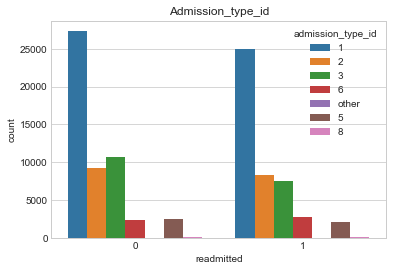

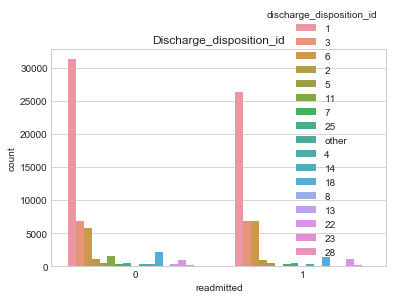

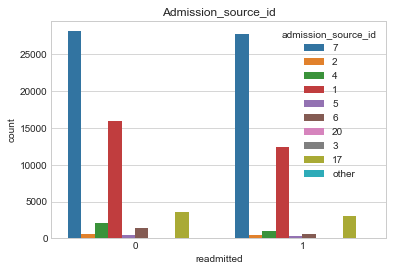

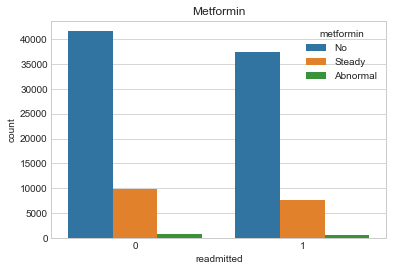

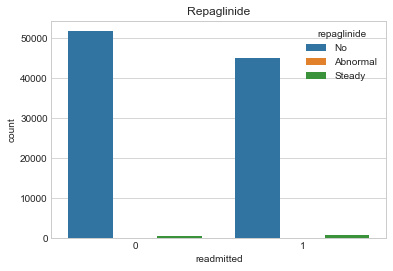

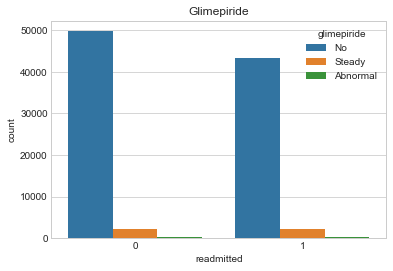

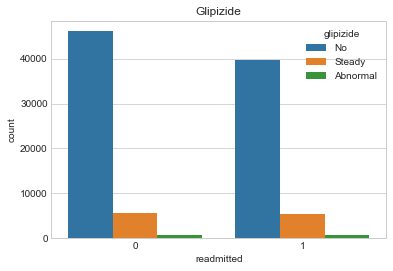

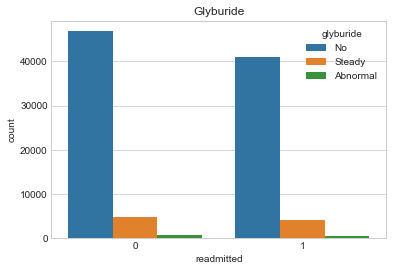

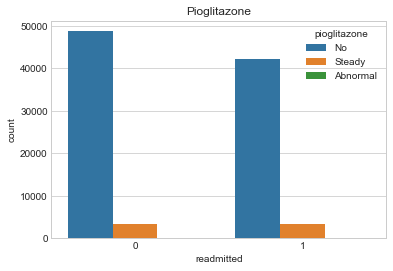

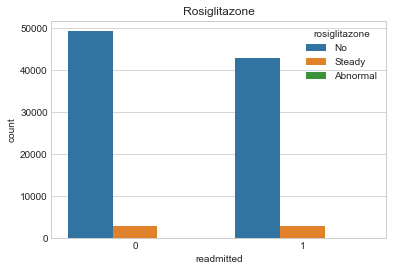

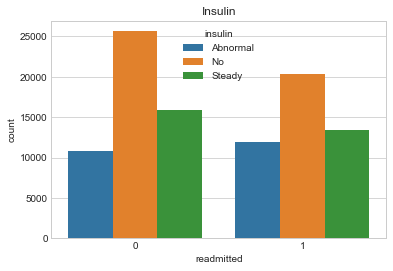

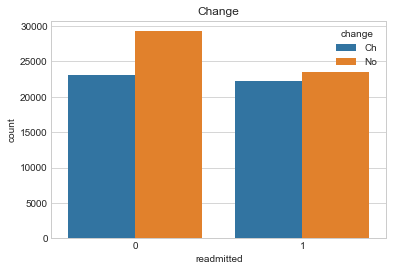

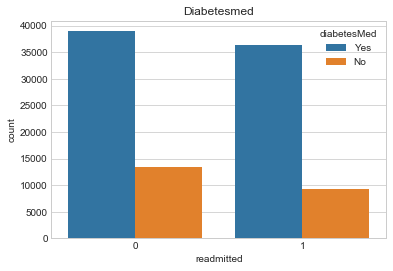

In [42]:
# Plot categorical variable
fig, axs = plt.subplots(ncols=1)
for i, col in enumerate(X_cat_vis.columns):
    if col not in ['readmitted', 'diag_1', 'diag_2', 'diag_3']:
        plt.figure(i)       
        sns.countplot(x='readmitted', data=X_cat_vis, hue=col)
        plt.title(col.capitalize())

In [43]:
#Visualize continuous data
X_cont_vis = X_cont
X_cont_vis['readmitted'] = Y_new
X_cont_vis.columns

Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'readmitted'],
      dtype='object')

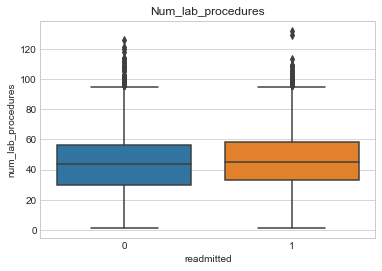

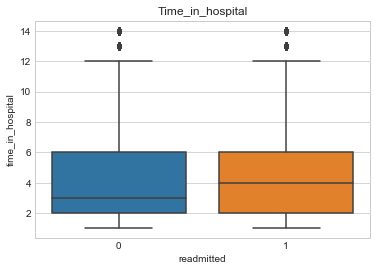

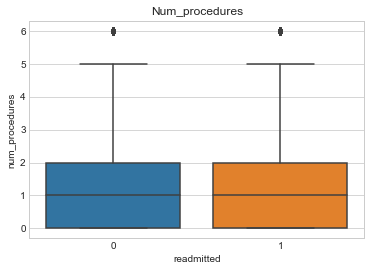

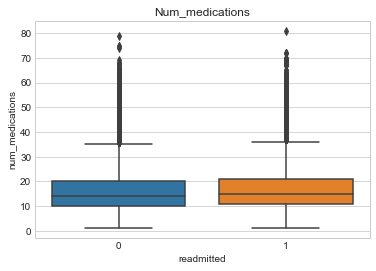

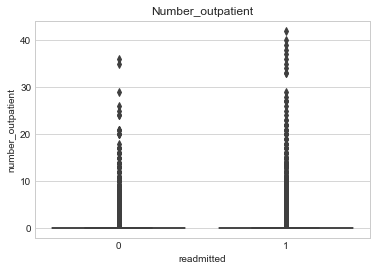

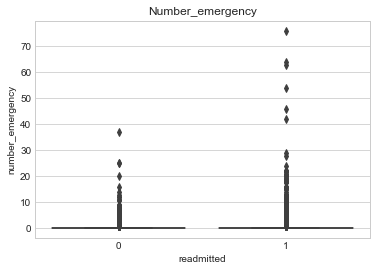

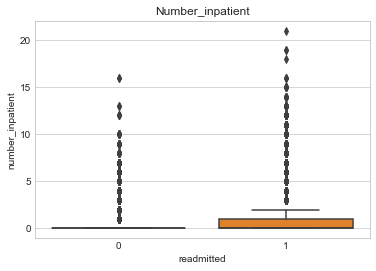

In [44]:
#Plot continuous variable
fig, axs = plt.subplots(ncols=1)

for i, col in enumerate(X_cont_vis.columns):
    if col !='readmitted':
        plt.figure(i)    
        sns.boxplot(x='readmitted', y=col, data=X_cont_vis)
        plt.title(col.capitalize())

In [45]:
#Get statistics from continuous values
X[continuous_columns].describe()
X_cont_vis.describe()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,readmitted
count,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000
mean,4.422011,43.148462,1.350712,16.119590,0.376382,0.202464,0.646871,0.466232
std,2.993070,19.711757,1.708475,8.108496,1.283365,0.942897,1.271025,0.498861
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,31.000000,0.000000,11.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,0.000000
75%,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,1.000000
max,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,1.000000


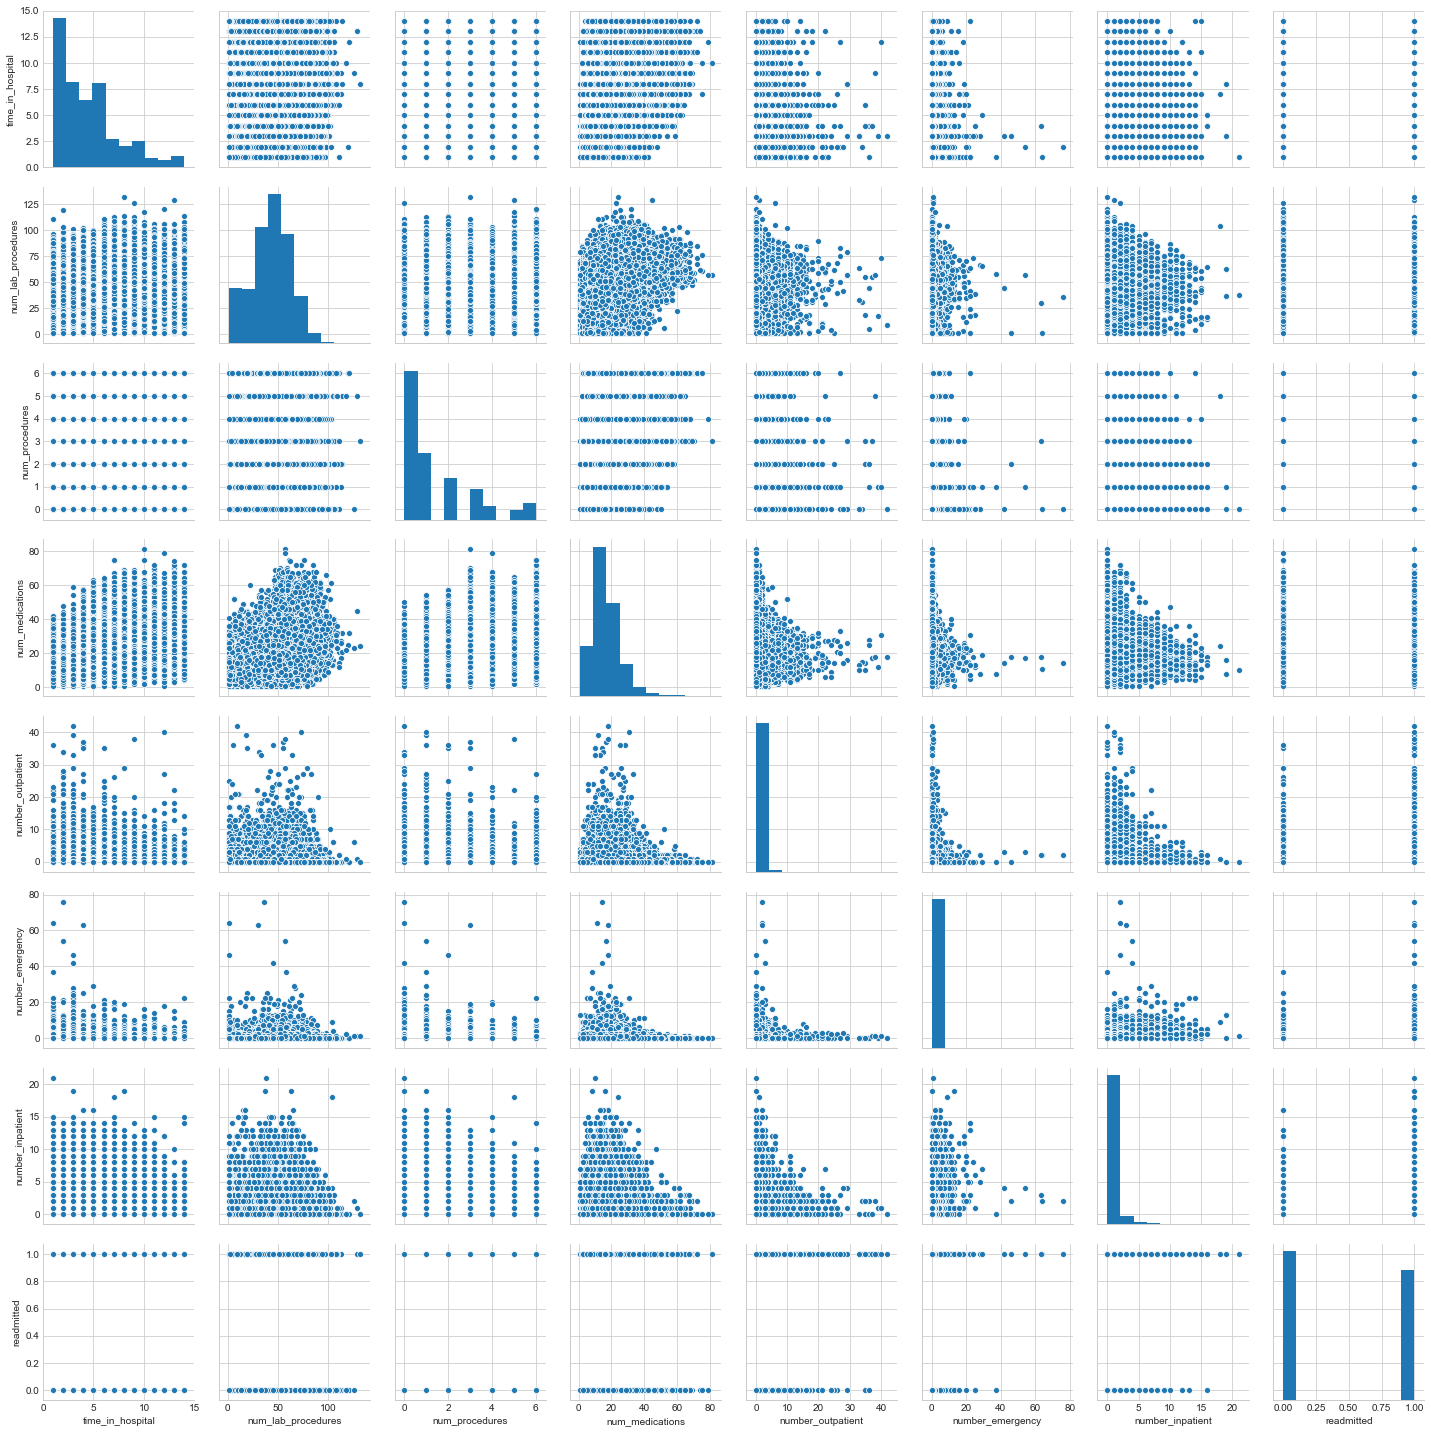

In [46]:
sns.pairplot(X_cont_vis)

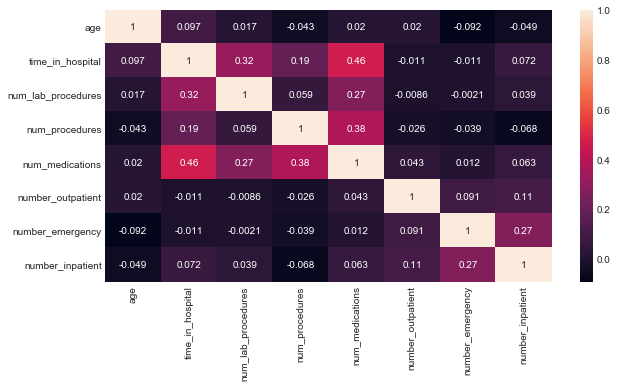

In [47]:
#Get heatmap of correlations
plt.figure(figsize=(10,5))
sns.heatmap(X.corr(), annot=True)

In [48]:
#Create dataset for tree based algorithms that do not require one hot encoding
X_final_no_OHE = X
X_final_no_OHE['readmitted'] = Y_new

In [49]:
X_final_no_OHE.shape

(98052, 27)

In [50]:
# Save a copy of the preprocessed data
X_final_no_OHE.to_csv("1_dataset_ML_no_OHE_ready.csv")

In [51]:
#Create dataset for non tree based algorithms that require one hot encoding
X_final = pd.get_dummies(X, prefix=None, prefix_sep='_', 
                        dummy_na=False, columns=categorical_columns, 
                        sparse=False, 
                        drop_first=True, dtype=None)

In [52]:
X_final.shape

(98052, 472)

In [53]:
X_final['readmitted'] = Y_new

In [54]:
# Save a copy of the preprocessed data
X_final.to_csv("1_dataset_ML_OHE_ready.csv")